In [1]:
import json
import csv
import numpy
import pytz
import pandas as pd
from binance.client import Client
import spacy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime
%matplotlib inline

# Get the coin price data from Binance.

Set up the Binance API to get the data we need.

In [2]:
client = Client("", "")

interval = Client.KLINE_INTERVAL_1MINUTE
start = "1 January, 2018"
end = "1 April, 2018"

The following function will get the historical price data for a given symbol (e.g. ETH) over the time interval.

In [3]:
def get_price_data(symbol):
    sym = symbol + "BTC"
    klines = client.get_historical_klines(sym, interval, start, end)

    j = []
    for t in klines:
        row = [t[6], t[4], t[2], t[3], t[5], t[8]]
        j.append(row)
    return j

Each output has the follow structure
[Close time, Close price, High, Low, Volume, Number of trades]

In [4]:
eth_price = get_price_data('ETH')

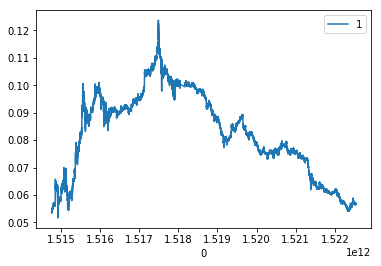

In [5]:
price_df = pd.DataFrame(eth_price)
price_df.head()
price_df = price_df.astype(float)
price_df.plot.line(x=0, y=1)

# Reddit comment sentiment

In [6]:
filename = "../RC_2018-01-06_crypto"
coinfile = "coins_on_binance.csv"
nlp = spacy.load('en')
occurances = {}

Get a list of coins on Binance:

In [7]:
with open(coinfile) as cf:
        rdr = csv.reader(cf)
        coins = []
        for row in rdr:
            coins.append(row)

Divide the comments based on references to coins:

In [8]:
with open (filename) as f:
    all_data = json.load(f)
for rc in all_data:
    spcomment = nlp(rc['body'])
    for symbol_line in coins:
        symbol = symbol_line[1]
        name = symbol_line[0]
        has_symbol = False
        comment_dict = {'time': rc['created_utc'], 'body': rc['body'],
                        'sentences' : [], 'subreddit': rc['subreddit']}
        for sentence in spcomment.sents:
            for word in sentence:
                if word.text.lower() == symbol.lower() or word.text.lower() == name.lower():
                    has_symbol = True
                    comment_dict['sentences'].append(sentence.text)
                    break
        if has_symbol:
            if symbol in occurances:
                occurances[symbol].append(comment_dict)
            else:
                occurances[symbol] = [comment_dict]

Sentiment:

In [35]:
goodwords = []
badwords = []

with open("good-words") as f:
    goodwords = [line.rstrip() for line in f]

with open("bad-words") as f:
    badwords = [line.rstrip() for line in f]


In [39]:
def check_sentiment(comment):
    good = 0
    bad = 0
    words = comment.lower().split()
   
    c = Counter(words)
    for g in goodwords:
        if g in words:
           
            good += c[g]
    for b in badwords:
        if b in words:
           
            bad += c[b]
    return good - bad

In [40]:
for coin in occurances:
    for comment in occurances[coin]:
        comment['sentiment'] = check_sentiment(comment['body'])

Plotting things:

In [41]:
def plot_mentions(symbol_data, symbol):
    symoccurances_df = pd.DataFrame(symbol_data)
    symoccurances_df.head()
    symoccurances_df.plot(kind= 'hist', bins = 300, x = 'time')

In [43]:
def plot_length(symbol_data, symbol):
    for c in symbol_data:
        clen = 0
        for sentence in c['sentences']:
            clen += len(sentence)

        c['length'] = clen
       

    df = pd.DataFrame(symbol_data)
    df.head()
    df.plot.bar(x = 'time', y ='length', title=symbol, color='blue')

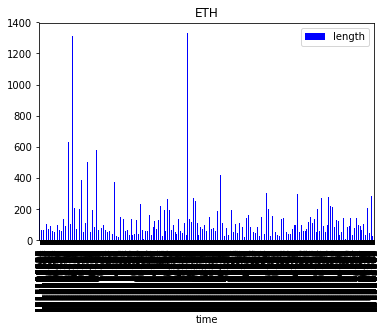

In [44]:
plot_length(occurances['ETH'], 'ETH')

In [50]:
def plot_sentiment(symbol_data, symbol):
    symoccurances_df = pd.DataFrame(symbol_data)
    symoccurances_df.head()
    symoccurances_df.plot(x = 'time', y = 'sentiment')

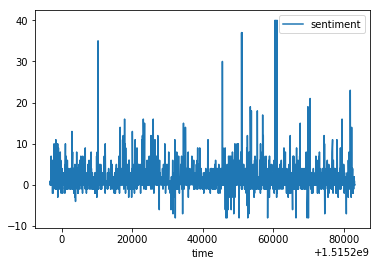

In [51]:
plot_sentiment(occurances['ETH'], 'ETH')